In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [29]:
MODEL = 1 # 0 = th v air, 1 = el v sky

In [30]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/vae_synthetic_data/{model_name}_generated_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/vae_synthetic_data/{model_name}_rescaled_samples.npy')

gan_data_train = np.load(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy')
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy')

base_data_train, base_data_test, vae_data_train = base_data_train[:,:,index], base_data_test[:,:,index], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape,gan_data_train.shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


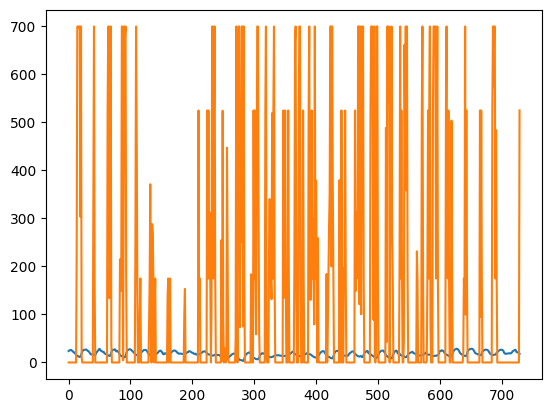

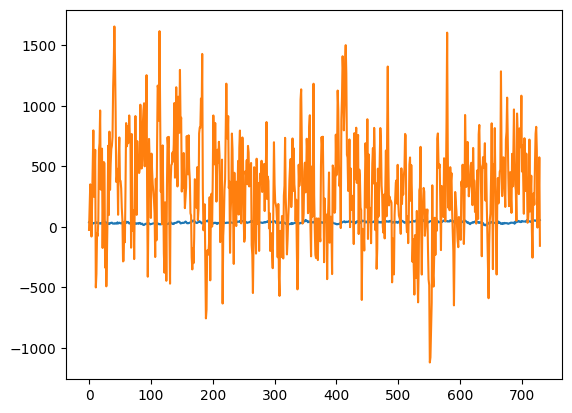

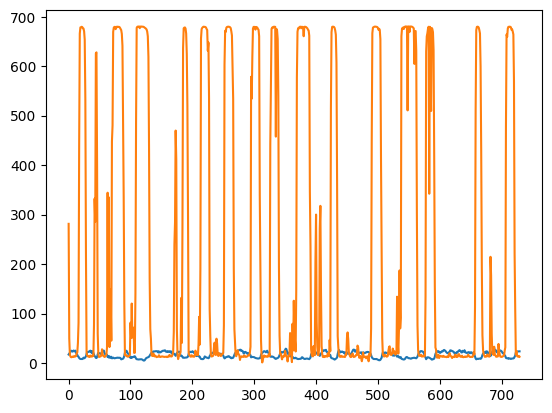

In [31]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[200])
plt.show()
plt.plot(gan_data_train_rescaled[200])
plt.show()

In [30]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [32]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [33]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [34]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'accuracy'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae, accuracy = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy(), 'acc':accuracy}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [35]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


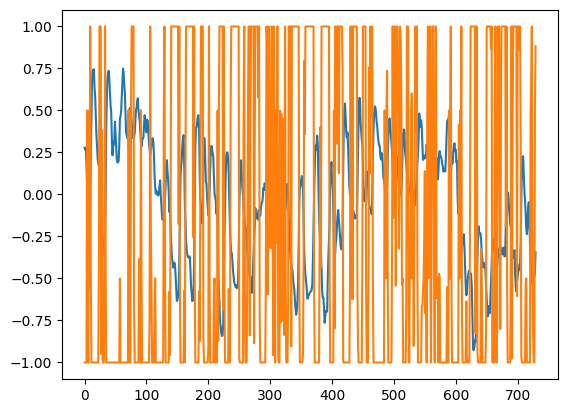

In [36]:
plt.plot(scaled_data_train[10])

Clip energy consumption at 0 and rescale

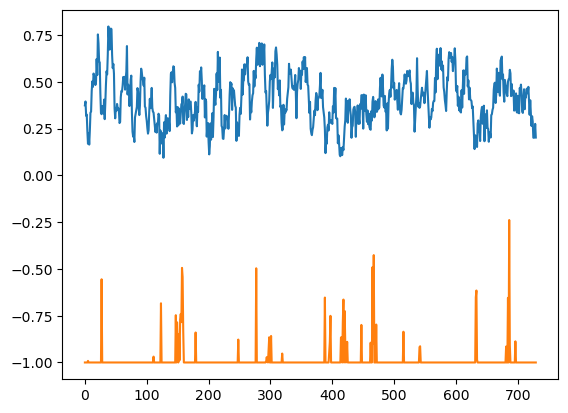

In [36]:
clipped_vae_train = np.clip(vae_data_train_rescaled, a_min=0, a_max=None)
clipped_temp, clipped_energy = clipped_vae_train[:,:,0], clipped_vae_train[:,:,1]
clipped_temp, clipped_energy = scalers['G.air.T'].fit_transform(clipped_temp), scalers['G.E_th_I'].fit_transform(clipped_energy) 

clipped_vae_train = np.stack((clipped_temp, clipped_energy), axis=-1)
plt.plot(clipped_vae_train[50])

In [24]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [46]:
def test_cnn_wrapper(data):
    mse, mae, r2 = 0, 0, 0

    # Run each CNN training 10 times to ensure results are significant and not outliers
    for i in range(10):
        print(f'RUN: {i}')
        results = test_cnn(data)
        mse += results['mse']
        mae += results['mae']
        r2  += results['r2']

    return {'mse':mse/10, 'mae':mae/10, 'r2':r2/10}
        

<h3> Use CNN to assess ground truth data </h3>

In [48]:
gt_test = test_cnn_wrapper(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'])

RUN: 0
Epoch 1/100
6/6 [==============================] - 1s 62ms/step - loss: 0.8167 - mse: 0.8167 - mae: 0.8648 - accuracy: 0.0000e+00 - val_loss: 0.7871 - val_mse: 0.7871 - val_mae: 0.8373 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 29ms/step - loss: 0.7322 - mse: 0.7322 - mae: 0.7817 - accuracy: 0.0000e+00 - val_loss: 0.7407 - val_mse: 0.7407 - val_mae: 0.8036 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 28ms/step - loss: 0.6611 - mse: 0.6611 - mae: 0.7175 - accuracy: 0.0000e+00 - val_loss: 0.7052 - val_mse: 0.7052 - val_mae: 0.7609 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 0.6171 - mse: 0.6171 - mae: 0.6703 - accuracy: 0.0000e+00 - val_loss: 0.6915 - val_mse: 0.6915 - val_mae: 0.7574 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.5939 - mse: 0.5939 

<h3> Use CNN to assess synthetic data</h3>

VAEs

In [49]:
synth_test = test_cnn_wrapper(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 44ms/step - loss: 1.8191 - mse: 1.8191 - mae: 1.0499 - accuracy: 0.0058 - val_loss: 1.5494 - val_mse: 1.5494 - val_mae: 0.9562 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 1.5470 - mse: 1.5470 - mae: 0.9638 - accuracy: 0.0000e+00 - val_loss: 1.3868 - val_mse: 1.3868 - val_mae: 0.9239 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 25ms/step - loss: 1.3154 - mse: 1.3154 - mae: 0.8898 - accuracy: 0.0058 - val_loss: 1.2110 - val_mse: 1.2110 - val_mae: 0.8473 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 1.0611 - mse: 1.0611 - mae: 0.8044 - accuracy: 0.0116 - val_loss: 1.1900 - val_mse: 1.1900 - val_mae: 0.8289 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 25ms/step - loss: 1.0455 - mse: 1.0455 - mae: 0.7968 

GANs

In [50]:
synth_test_gan = test_cnn_wrapper(gan_data_train[0:216,:,:])
print(synth_test_gan['mse'], synth_test_gan['mae'], synth_test_gan['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 42ms/step - loss: 0.8034 - mse: 0.8034 - mae: 0.8634 - accuracy: 0.0000e+00 - val_loss: 0.7919 - val_mse: 0.7919 - val_mae: 0.8573 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 0.7339 - mse: 0.7339 - mae: 0.7934 - accuracy: 0.0000e+00 - val_loss: 0.7615 - val_mse: 0.7615 - val_mae: 0.8188 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 25ms/step - loss: 0.7008 - mse: 0.7008 - mae: 0.7592 - accuracy: 0.0058 - val_loss: 0.7510 - val_mse: 0.7510 - val_mae: 0.8041 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 0.6880 - mse: 0.6880 - mae: 0.7467 - accuracy: 0.0174 - val_loss: 0.7379 - val_mse: 0.7379 - val_mae: 0.7885 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 24ms/step - loss: 0.6756 - mse: 0.6756 - 

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

VAEs

In [51]:
blended_data = np.concatenate((scaled_data_train, vae_data_train[0:216,:,:]), axis=0)
blended_test = test_cnn_wrapper(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'])

RUN: 0
Epoch 1/100
17/17 [==============================] - 1s 34ms/step - loss: 1.4490 - mse: 1.4490 - mae: 0.9713 - accuracy: 0.0077 - val_loss: 1.3003 - val_mse: 1.3003 - val_mae: 0.9512 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 23ms/step - loss: 1.2512 - mse: 1.2512 - mae: 0.9050 - accuracy: 0.0039 - val_loss: 1.2687 - val_mse: 1.2687 - val_mae: 0.9296 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 1.1753 - mse: 1.1753 - mae: 0.8742 - accuracy: 0.0077 - val_loss: 1.2589 - val_mse: 1.2589 - val_mae: 0.9194 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 1.1492 - mse: 1.1492 - mae: 0.8540 - accuracy: 0.0077 - val_loss: 1.0554 - val_mse: 1.0554 - val_mae: 0.8377 - val_accuracy: 0.0308 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 23ms/step - loss: 0.9413 - mse: 0.9413 - mae: 0.7799 

In [53]:
blended_data_gan = np.concatenate((scaled_data_train, gan_data_train[0:216,:,:]), axis=0)
blended_test_gan = test_cnn_wrapper(blended_data_gan)
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

RUN: 0
Epoch 1/100
17/17 [==============================] - 2s 39ms/step - loss: 0.7883 - mse: 0.7883 - mae: 0.8425 - accuracy: 0.0000e+00 - val_loss: 0.7332 - val_mse: 0.7332 - val_mae: 0.8181 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 27ms/step - loss: 0.7186 - mse: 0.7186 - mae: 0.7728 - accuracy: 0.0039 - val_loss: 0.6912 - val_mse: 0.6912 - val_mae: 0.7714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 1s 30ms/step - loss: 0.7017 - mse: 0.7017 - mae: 0.7538 - accuracy: 0.0116 - val_loss: 0.6689 - val_mse: 0.6689 - val_mae: 0.7434 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 0.6899 - mse: 0.6899 - mae: 0.7507 - accuracy: 0.0116 - val_loss: 0.6649 - val_mse: 0.6649 - val_mae: 0.7212 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 26ms/step - loss: 0.6728 - mse: 0.6728 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [54]:
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

0.542573070526123 0.5833045780658722 0.20557679533958434
